In [142]:
import numpy as np
import time
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

In [310]:
lines = []
topics = []
creds = []
with open('cred_event_TurkRatings.data', 'r') as f:
    f.readline()
    for l in f.readlines():
        vals = l.split('	')
        keywords = [s.strip("''") for s in (vals[1][2:]).strip("][").split(', u')]
        topics.append(keywords)
        ratings = [int(i.strip("\'\'")) for i in vals[2].strip("][").split(', ')]
        creds.append(np.mean(ratings))

In [311]:
terms = set()
for t in topics:
    for word in t:
        terms.add(word)
term_list = sorted(list(terms))

In [312]:
term_topic_mat = np.zeros((len(topics), len(term_list)))

In [313]:
for ind, i in enumerate(term_list):
    for jnd, j in enumerate(topics):
        if i in j:
            term_topic_mat[jnd, ind] += 1


## Regression Task

In [314]:
n_features = term_topic_mat.shape[1]

In [324]:
def accuracy(y, outs):
    diffs = y - outs
    count = torch.abs(diffs) < .5
    return sum(count) / len(y)
def round_accuracy(y, outs):
    nas = (y < 1) & (outs < 1)
    kas = (y >= 1) & (y < 1.5) & (outs >= 1) & (outs < 1.5)
    vas = (y >= 1.5) & (outs >=1.5)
    
    return (sum(nas) + sum(kas) + sum(vas)) / len(y)

In [298]:
(X_train, X_test, y_train, y_test) = train_test_split(term_topic_mat, np.array(creds), test_size=0.2, random_state=7)

In [377]:
class RegressionModel(nn.Module):
    def __init__(self, n_features, n_hidden=64, p_dropout=0):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return self.network(x)

In [425]:
def run_experiment(epochs, model_width, batch_size, learning_rate=.001):
    # reset the model
    model = RegressionModel(n_features=n_features, n_hidden=model_width)
    model_criterion = nn.MSELoss() 
    model_optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).float())
    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).float())
    test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    # number of epochs and iterations
    #epochs = 100
    #iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    
    # plotting criteria
    train_losses = []
    test_accs = []
    train_accs = []
    test_class_accs = []
    
    local_X_train = torch.from_numpy(X_train).float()
    local_y_train = torch.from_numpy(y_train).float()
    local_X_test = torch.from_numpy(X_test).float()
    local_y_test = torch.from_numpy(y_test).float()
    
    for epoch in range(epochs):

        for x_batch_train, y_batch_train in train_loader:
            
            model_optimizer.zero_grad()


            outputs = model.forward(x_batch_train)
            loss = model_criterion(torch.squeeze(outputs), y_batch_train)
            train_losses.append(loss)
            loss.backward()


            model_optimizer.step()

        
    
        lossfn = model_criterion
        train_outs = torch.squeeze(model.forward(local_X_train))
        test_outs = torch.squeeze(model.forward(local_X_test))
        #avg_train_l = lossfn(train_outs, local_y_train)
        #avg_test_l = lossfn(test_outs, local_y_test)


        train_a = accuracy(local_y_train, train_outs)
        test_a = accuracy(local_y_test, test_outs)
        class_a = round_accuracy(local_y_test, test_outs)
        
        train_accs.append(train_a)
        test_accs.append(test_a)
        test_class_accs.append(class_a)
        print(f"E: {epoch}, Regression Accuracy:  {float(test_a)},  Classification Accuracy: {float(class_a)}")
        
    return train_accs, test_accs, test_class_accs, model

In [427]:
stuff = run_experiment(10, 16, 2, learning_rate=.00015)

E: 0, Regression Accuracy:  0.025362318381667137,  Classification Accuracy: 0.021739130839705467
E: 1, Regression Accuracy:  0.9528985619544983,  Classification Accuracy: 0.8369565010070801
E: 2, Regression Accuracy:  0.9637681245803833,  Classification Accuracy: 0.8369565010070801
E: 3, Regression Accuracy:  0.9601449370384216,  Classification Accuracy: 0.8442028760910034
E: 4, Regression Accuracy:  0.967391312122345,  Classification Accuracy: 0.8478260636329651
E: 5, Regression Accuracy:  0.967391312122345,  Classification Accuracy: 0.8260869383811951
E: 6, Regression Accuracy:  0.9710144996643066,  Classification Accuracy: 0.7898550629615784
E: 7, Regression Accuracy:  0.9710144996643066,  Classification Accuracy: 0.7789855003356934
E: 8, Regression Accuracy:  0.9710144996643066,  Classification Accuracy: 0.7789855003356934
E: 9, Regression Accuracy:  0.9710144996643066,  Classification Accuracy: 0.7789855003356934


In [404]:
widths = [16, 32]
lrs = [.0075, .01]
batch_sizes = [2, 4, 8, 16]
#info_tups = []
for i in range(1):
    (X_train, X_test, y_train, y_test) = train_test_split(term_topic_mat, np.array(creds), test_size=0.2)
    for w in widths:
        for b in batch_sizes:
            for l in lrs:
                train_acc, test_acc, test_class_accs, model = run_experiment(10, w, b, learning_rate=l)
                info_tups.append((w, b, l, max(test_acc).numpy(), test_acc[-1].numpy(), np.argmax(test_acc), max(test_class_accs)))

In [405]:
df = pd.DataFrame(info_tups, dtype=float)
df.columns = ["width", 'batch size','learning rate', 'max accuracy', 'last accuracy', 'max at epoch', 'class accs']

In [406]:
gb = df.groupby(['width', 'batch size', 'learning rate'])
groups = gb.agg({'max accuracy' : ["mean"], 'class accs' : ["mean"]})

In [415]:
groups[0:50]

max accuracy class accs
                                       mean       mean
width batch size learning rate                        
16.0  2.0        0.00010           0.960145   0.833333
                 0.00025           0.956522   0.840580
                 0.00050           0.960145   0.840580
                 0.00075           0.960145   0.855072
                 0.00100           0.960145   0.807971
                 0.00200           0.963768   0.858696
                 0.00250           0.945652   0.822464
                 0.00300           0.956522   0.829710
                 0.00500           0.949275   0.851449
                 0.00750           0.974638   0.851449
                 0.01000           0.974638   0.847826
      4.0        0.00010           0.952899   0.793478
                 0.00025           0.956522   0.826087
                 0.00050           0.952899   0.829710
                 0.00075           0.967391   0.873188
                 0.00100           0.960145   0.844203
                 0.00200           0.960145   0.807971
                 0.00250           0.949275   0.836957
                 0.00300           0.945652   0.826087
                 0.00500           0.949275   0.862319
                 0.00750           0.967391   0.826087
                 0.01000           0.971014   0.851449
      8.0        0.00010           0.913043   0.702899
                 0.00025           0.931159   0.760870
                 0.00050           0.942029   0.793478
                 0.00075           0.945652   0.804348
                 0.00100           0.942029   0.782609
                 0.00200           0.960145   0.836957
                 0.00250           0.945652   0.829710
                 0.00300           0.952899   0.822464
                 0.00500           0.949275   0.847826
                 0.00750           0.974638   0.836957
                 0.01000           0.967391   0.847826
      16.0       0.00075           0.942029   0.728261
                 0.00200           0.960145   0.865942
                 0.00250           0.942029   0.822464
                 0.00300           0.949275   0.800725
                 0.00500           0.952899   0.844203
                 0.00750           0.960145   0.815217
                 0.01000           0.963768   0.778986
32.0  2.0        0.00010           0.952899   0.836957
                 0.00025           0.956522   0.829710
                 0.00050           0.960145   0.844203
                 0.00075           0.960145   0.862319
                 0.00100           0.956522   0.818841
                 0.00200           0.971014   0.844203
                 0.00250           0.956522   0.847826
                 0.00300           0.945652   0.855072
                 0.00500           0.960145   0.855072
                 0.00750           0.967391   0.851449

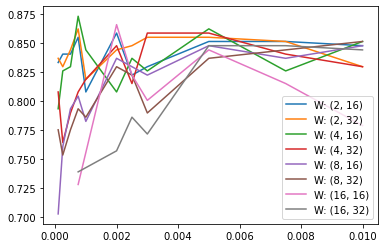

In [409]:
for b in [2, 4, 8, 16]:
    for w in widths:
        d = df[(df['batch size'] == b) & (df['width'] == w)].sort_values('learning rate')
        plt.plot(d['learning rate'], d['class accs'], label=f"W: {b, w}")
plt.legend()
plt.show()

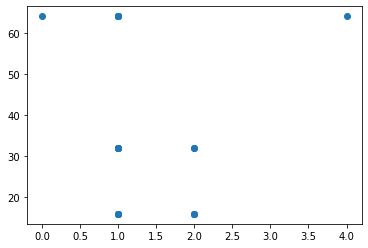

In [167]:
plt.scatter(df['max at epoch'], df['width'])

## Classification Task

In [218]:
cred_classes = []
for value in creds:
    if value < 1:
        cred_classes.append(0)
    elif value < 1.5:
        cred_classes.append(1)
    else:
        cred_classes.append(2)

In [235]:
def class_accuracy(y, out):
    values, indices = out.max(dim=1)
    accuracy = sum(indices == y) / len(y)
    return accuracy

In [351]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=16, p_dropout=0):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_classes),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.network(x)

In [410]:
def run_class_experiment(epochs, model_width, batch_size, dropout=.2):
    # dataset
    (X_class_train, X_class_test, y_class_train, y_class_test) = train_test_split(term_topic_mat, np.array(cred_classes), test_size=0.2)
    training_dataset = TensorDataset(torch.from_numpy(X_class_train).float(), 
                                 torch.from_numpy(y_class_train).long())
    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    testing_dataset = TensorDataset(torch.from_numpy(X_class_test).float(), 
                                torch.from_numpy(y_class_test).long())
    test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # model 
    model = Classifier(n_features=n_features, n_classes = 3, n_hidden=model_width, p_dropout=dropout)
    model_criterion = nn.NLLLoss()
    model_optimizer = torch.optim.Adam(model.parameters(),lr=0.00075)


    # number of epochs and iterations
    #epochs = 100
    #iters = epochs * BATCH_SIZE
    
    # plotting criteria
    train_losses = []
    test_accs = []
    train_accs = []
    local_X_train = torch.from_numpy(X_class_train).float()
    local_y_train = torch.from_numpy(y_class_train).long()
    local_X_test = torch.from_numpy(X_class_test).float()
    local_y_test = torch.from_numpy(y_class_test).long()
    
    for epoch in range(epochs):

        for x_batch_train, y_batch_train in train_loader:
            
            model_optimizer.zero_grad()


            outputs = model.forward(x_batch_train)
            loss = model_criterion(torch.squeeze(outputs), y_batch_train)
            train_losses.append(loss)
            loss.backward()


            model_optimizer.step()

        
    
        lossfn = model_criterion
        train_outs = model(local_X_train)
        test_outs = model(local_X_test)
        avg_train_l = lossfn(train_outs, local_y_train)
        avg_test_l = lossfn(test_outs, local_y_test)

        train_a = class_accuracy(local_y_train, train_outs)
        test_a = class_accuracy(local_y_test, test_outs)
        train_accs.append(train_a)
        test_accs.append(test_a)
        print(f"Epoch: {epoch},   Train acc: {train_a},  Test acc: {test_a}")
        
        
    return train_losses, train_accs, test_accs, model

In [411]:
tl, train_a, test_a, model = run_class_experiment(10, 16, 4, dropout=0)

/Users/tim/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0,   Train acc: 0.8430126905441284,  Test acc: 0.8514492511749268
Epoch: 1,   Train acc: 0.8430126905441284,  Test acc: 0.8514492511749268
Epoch: 2,   Train acc: 0.8430126905441284,  Test acc: 0.8514492511749268
Epoch: 3,   Train acc: 0.8738657236099243,  Test acc: 0.8442028760910034
Epoch: 4,   Train acc: 0.9219600558280945,  Test acc: 0.8188405632972717
Epoch: 5,   Train acc: 0.9401088953018188,  Test acc: 0.8079710006713867
Epoch: 6,   Train acc: 0.9464609622955322,  Test acc: 0.7862318754196167
Epoch: 7,   Train acc: 0.9519056081771851,  Test acc: 0.77173912525177
Epoch: 8,   Train acc: 0.9537205100059509,  Test acc: 0.7572463750839233
Epoch: 9,   Train acc: 0.9573502540588379,  Test acc: 0.7644927501678467
